In [ ]:
import yaml 
from torchvision import transforms, datasets
import random
import os
import numpy as np

### Loading the imagenet graph

In [ ]:
G = nx.DiGraph()

In [ ]:
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')

# Add edges
G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('B', 'D')

In [ ]:

#nx.draw_networkx(G, nx.spring_layout(G))
G.remove_node('D')
nx.draw_networkx(G, nx.spring_layout(G))

In [ ]:
with open("data/imagenette2/synset_human.txt", "r") as f:    
    synset_human_complete = f.read().splitlines()
    synset_human_complete = dict(line.split(maxsplit=1) for line in synset_human_complete)

In [ ]:
from imagenet_classnames import name_map, folder_label_map

synset_human = folder_label_map
index_human = name_map

#check that synset_human keys are ordered
for i, (key_syn, key_index) in enumerate(zip(sorted(synset_human.keys()), sorted(index_human.keys()))):
    assert synset_human[key_syn] == index_human[key_index]
    assert i == key_index

index_synset = { i: k for i, k in enumerate(synset_human.keys())}

# validate the index_synset with index to human
for index in index_synset.keys():
    assert index_human[index] == synset_human[index_synset[index]]


In [ ]:
with open('data/wordnet.is_a.txt', 'r') as f:
    data = f.read()
#convert from synset to human and save to file
with open('data/wordnet.is_a_human.txt', 'w') as f:
    for line in data.splitlines():
        synset1, synset2 = line.split()
        f.write(f'{synset_human_complete[synset2]} is a {synset_human_complete[synset1]}\n')

In [ ]:
# Create an empty directed graph object
G_hum = nx.DiGraph()
G_syn = nx.DiGraph()

# Open the file and read its contents
with open('data/wordnet.is_a.txt', 'r') as f:
    data = f.read()

# Split the data into lines and iterate over each line
for line in data.split('\n'):
    # Split the line into parent and child node IDs
    if len(line) > 0:
        parent, child = line.split()
        if parent in synset_human: 
            #print("parent is a leaf in imagenet", parent, synset_human[parent], '\n')
            #print("the child is", child, synset_human_complete[child], '\n')
            assert child not in synset_human, "child is in imagenet"
            continue
        # Add an edge between the parent and child nodes
        G_hum.add_edge(synset_human_complete[parent], synset_human_complete[child])
        G_syn.add_edge(parent, child)

# Print the nodes and edges in the graph
print("Nodes:", sorted(G_syn.nodes()))
print(sorted(synset_human.keys()))
#print("Edges:", G1.edges())

In [ ]:
len(synset_human)

In [ ]:
# get duplicated human labels
from collections import Counter
duplicates = [k for k,v in Counter(synset_human.values()).items() if v>1]
duplicates


In [ ]:
for key in synset_human.keys():
    assert key in G_syn.nodes(), "key is in imagenet but not in graph"  

In [ ]:
# #remove the leaf nodes that are not in imagenet
# for node in list(G1.nodes):
#     if node not in human_synset and G1.out_degree(node) == 0:
#         if node == "volleyball player":
#             print("removing", node, '\n')
#         G1.remove_node(node)

# for node in list(G2.nodes):
#     if node not in human_synset and G2.out_degree(node) == 0:
#         G2.remove_node(node)


In [ ]:
#recursively remove the leaf nodes that are not in imagenet
def remove_leaf_nodes(G):
    len_before = len(G.nodes())
    for node in list(G.nodes()):
        if G.out_degree(node) == 0 and node not in synset_human.values():
            G.remove_node(node)
            #print("removing node", node)
    len_after = len(G.nodes())
    print("len before", len_before, "len after", len_after)
    
    if len_before != len_after:
        remove_leaf_nodes(G)
    return G

#recursively remove the leaf nodes that are not in imagenet
def remove_leaf_node_syn(G):
    len_before = len(G.nodes())
    nodes_in_imagenet = [node for node in G.nodes() if node in synset_human]
    nodes_not_in_imagenet = [node for node in G.nodes() if node not in synset_human]
    total_nodes = len(nodes_in_imagenet)
    print("total nodes in imagenet", total_nodes)
    print("nodes in imagenet", len(nodes_in_imagenet))
    for node in nodes_not_in_imagenet:
        if G.out_degree(node) == 0:
            G.remove_node(node)
            #print("removing node", node)
    # for node in list(G.nodes()):

    #     if G.out_degree(node) == 0 and node not in synset_human:
    #         #print("removing node", node, synset_human[node])
    #         G.remove_node(node)
    #         #print("removing node", node)
    len_after = len(G.nodes())
    print("len before", len_before, "len after", len_after)
    
    if len_before != len_after:
        remove_leaf_node_syn(G)
    return G


In [ ]:
G_hum_filtered = remove_leaf_nodes(G_hum)

In [ ]:
G_syn_filtered = remove_leaf_node_syn(G_syn)

In [ ]:
leaf_nodes =[node for node in list(G_syn.nodes) if G_syn.out_degree(node) == 0]

In [ ]:
len(set(leaf_nodes).intersection(set(synset_human.keys()))), len(leaf_nodes), len(synset_human.keys())

In [ ]:
from collections import defaultdict

In [ ]:
def closest_leaf_nodes(G, orig_node, parents = None, k=4, siblings_ordered=defaultdict(list)):
    # if len(siblings_ordered[orig_node]) >= k:
    #     print("returning top")
    #     return siblings_ordered[orig_node][:k]
    # Get the parent node
    if parents is None:
        #print("parents is none")
        parents = list(G.predecessors(orig_node))
        if len(parents) == 0:
            #print("NO more parents")
            return None
   # print(f"Siblings ordered at this level:", '\n', f"{[synset_human_complete[sibling] for sibling in siblings_ordered[orig_node]]}")
    #print(f"current parents are: {[synset_human_complete[parent] for parent in parents]}")
    # Get all direct sibling leaf nodes
    curr_siblings = []
    for parent in parents:
        #print(f"Searching for Parent {synset_human_complete[parent]}:", '\n')
        leaves_of_parent = [n for n in nx.dfs_preorder_nodes(G, parent) if G.out_degree(n) == 0 and n != orig_node and n not in siblings_ordered[orig_node]]
        #print(f"Leaves of Parent {synset_human_complete[parent]} are:", '\n')
        #print(f"{[synset_human_complete[leaf] for leaf in leaves_of_parent]}")
        curr_siblings.extend(leaves_of_parent)
    #print(orig_node, curr_siblings)
    #print(f"Curr Siblings:", '\n', f"{[synset_human_complete[sibling] for sibling in curr_siblings]}")
    distances = {}
    for sibling in curr_siblings:
        distances[sibling] = nx.shortest_path_length(G.to_undirected(as_view=True), orig_node, sibling)
    
    # Sort the siblings by distance and return the closest k
    closest = sorted(distances, key=distances.get)[:k]
    #print(f"Curr Siblings sorted:", '\n', f"{[synset_human_complete[sibling] for sibling in curr_siblings]}")

    siblings_ordered[orig_node].extend(closest)
    #print(f"Siblings ordered at this level:", '\n', f"{[synset_human_complete[sibling] for sibling in siblings_ordered[orig_node]]}")
    
    if len(siblings_ordered[orig_node]) >= k:
        #print(" len is greater than k")
        siblings_ordered[orig_node] = siblings_ordered[orig_node][:k]
        #print(f"returning {siblings_ordered[orig_node][:k]}")
        return None #siblings_ordered[orig_node][:k]
    
    else:
        #print("exploring parents of parents")
        # If there are less than k siblings, go up to the parent's parent and try again
        # get parents of parents
        parents_of_parents = []
        for parent in parents:
            parents_of_parents.extend(list(G.predecessors(parent)))
        
        x = closest_leaf_nodes(G, orig_node, parents_of_parents, k, siblings_ordered)

        return 
            

In [ ]:
def closest_leaf_nodes(G, orig_node, parents = None, k=4, siblings_ordered=defaultdict(list)):
    if parents is None:
        parents = list(G.predecessors(orig_node))
        if len(parents) == 0:
            return None
    curr_siblings = []
    for parent in parents:
        leaves_of_parent = [n for n in nx.dfs_preorder_nodes(G, parent) if G.out_degree(n) == 0 and n != orig_node and n not in siblings_ordered[orig_node]]
        curr_siblings.extend(leaves_of_parent)
    distances = {}
    for sibling in curr_siblings:
        distances[sibling] = nx.shortest_path_length(G.to_undirected(as_view=True), orig_node, sibling)
 
    closest = sorted(distances, key=distances.get)[:k]
 
    siblings_ordered[orig_node].extend(closest)


    if len(siblings_ordered[orig_node]) >= k:
        siblings_ordered[orig_node] = siblings_ordered[orig_node][:k]
        return None #siblings_ordered[orig_node][:k]
    
    else:

        parents_of_parents = []
        for parent in parents:
            parents_of_parents.extend(list(G.predecessors(parent)))
        
        x = closest_leaf_nodes(G, orig_node, parents_of_parents, k, siblings_ordered)
        return 
            

In [ ]:
siblings_ordered = defaultdict(list)
closest_leaf_nodes(G_syn_filtered, 'n01484850', k=4, siblings_ordered=siblings_ordered)

In [ ]:
print(siblings_ordered)

In [ ]:
for i in siblings_ordered['n01484850']:
    print(i)
    print(synset_human_complete[i])
    print('\n')

In [ ]:
siblings_ordered = defaultdict(list)
for i, node in enumerate(synset_human.keys(), 0):

    closest_leaf_nodes(G_syn_filtered, node, k=4, siblings_ordered=siblings_ordered)
    print("Node:", synset_human_complete[node], node)
    for sibling in siblings_ordered[node]:
        print("Sibling:", synset_human_complete[sibling])


In [ ]:
# save the siblings_ordered dict


In [ ]:
for node in x:
    print(synset_human_complete[node])

In [ ]:
siblings_hum = {}
for key, value in siblings_ordered.items():
    siblings_hum[synset_human_complete[key]] = [synset_human_complete[i] for i in value]

In [ ]:
su

In [ ]:
#invert the dict index_synset to synset_index
synset_index = {v: k for k, v in index_synset.items()}

In [ ]:
siblings_idx = {}
for key, value in siblings_ordered.items():
    siblings_idx[synset_index[key]] = [synset_index[i] for i in value]

In [ ]:
with open('data/image_idx_to_tgt_class_closest_5.yaml', 'w') as file:
    documents = yaml.dump(dict(siblings_ordered), file)


with open('data/image_idx_to_tgt_class_closest_5_human.yaml', 'w') as file:

    documents = yaml.dump(dict(siblings_hum), file)

with open('data/image_idx_to_tgt_class_closest_5_idx.yaml', 'w') as file:
    
        documents = yaml.dump(dict(siblings_idx), file)

### get data from artifact 

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('kifarid/cdiff/run-nfw1b6uy-dvce_video:v4', type='run_table')
df = pd.DataFrame(data=artifact.get("dvce_video").data, columns=artifact.get("dvce_video").columns)
memory_usage = df.memory_usage(deep=True).sum()
print(f"Memory usage of dataframe is {memory_usage/1e6} MB")
df.head()

### Creating the tgt_classes


In [ ]:



with open('data/synset_closest_idx.yaml', 'r') as file:
    synset_closest_idx = yaml.safe_load(file)


data_path = '/misc/scratchSSD2/datasets/ILSVRC2012/val'
out_size = 256
transform_list = [
    transforms.Resize((out_size,out_size)),
    transforms.ToTensor()
]
transform = transforms.Compose(transform_list)
dataset = datasets.ImageFolder(data_path,  transform=transform)

idx_image_to_tgt_class = {}
for i in range(len(dataset)):
    img, label = dataset[i]
    #print(synset_closest_idx[label], random.choice(synset_closest_idx[label]))
    idx_image_to_tgt_class[i] = random.choice(synset_closest_idx[label])
    if i%100==0:
        print(f"current image index: {i}")

In [ ]:
#convert default dict to dict


In [ ]:
with open('data/image_idx_to_tgt_class.yaml', 'w') as file:
    documents = yaml.dump(dict(idx_image_to_tgt_class), file)

### Creating the new Imagenet wrapper 

In [ ]:
with open('data/image_idx_to_tgt_class_closest_5.yaml', 'r') as file:
    image_idx_to_tgt_class_closest_5 = yaml.safe_load(file)

In [ ]:
from data.imagenet_classnames import name_map, folder_label_map

In [ ]:
class ImageNet(datasets.ImageFolder):
    classes = [name_map[i] for i in range(1000)]
    name_map = name_map

    def __init__(
            self, 
            root:str, 
            split:str="val", 
            transform=None, 
            target_transform=None, 
            class_idcs=None, 
            start_sample: int = 0, 
            end_sample: int = 50000//1000,
            return_tgt_cls: bool = False,
            idx_to_tgt_cls_path = None, 
            **kwargs
    ):
        _ = kwargs  # Just for consistency with other datasets.
        assert split in ["train", "val"]
        assert start_sample < end_sample and start_sample >= 0 and end_sample <= 50000//1000
        path = root if root[-3:] == "val" or root[-5:] == "train" else os.path.join(root, split)
        super().__init__(path, transform=transform, target_transform=target_transform)
        
        with open(idx_to_tgt_cls_path, 'r') as file:
            idx_to_tgt_cls = yaml.safe_load(file)
            if isinstance(idx_to_tgt_cls, dict):
                idx_to_tgt_cls = [idx_to_tgt_cls[i] for i in range(len(idx_to_tgt_cls))]
        self.idx_to_tgt_cls = idx_to_tgt_cls

        self.return_tgt_cls = return_tgt_cls

        if class_idcs is not None:
            class_idcs = list(sorted(class_idcs))
            tgt_to_tgt_map = {c: i for i, c in enumerate(class_idcs)}
            self.classes = [self.classes[c] for c in class_idcs]
            samples = []
            idx_to_tgt_cls = []
            for i, (p, t) in enumerate(self.samples):
                if t in tgt_to_tgt_map:
                    samples.append((p, tgt_to_tgt_map[t]))
                    idx_to_tgt_cls.append(self.idx_to_tgt_cls[i])
            
            self.idx_to_tgt_cls = idx_to_tgt_cls
            #self.samples = [(p, tgt_to_tgt_map[t]) for i, (p, t) in enumerate(self.samples) if t in tgt_to_tgt_map]
            self.class_to_idx = {k: tgt_to_tgt_map[v] for k, v in self.class_to_idx.items() if v in tgt_to_tgt_map}

        if "val" == split: # reorder
            new_samples = []
            idx_to_tgt_cls = []
            for idx in range(50000//1000):
                new_samples.extend(self.samples[idx::50000//1000])
                idx_to_tgt_cls.extend(self.idx_to_tgt_cls[idx::50000//1000])
            self.samples = new_samples[start_sample*1000:end_sample*1000]
            self.idx_to_tgt_cls = idx_to_tgt_cls[start_sample*1000:end_sample*1000]

        else:
            raise NotImplementedError

        self.class_labels = {i: folder_label_map[folder] for i, folder in enumerate(self.classes)}
        self.targets = np.array(self.samples)[:, 1]
    
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        if self.return_tgt_cls:
            return *sample, self.idx_to_tgt_cls[index]
        else:
            return sample

In [ ]:
image_idx_to_tgt_class_closest_5

In [ ]:
#convert dict to list 
image_idx_to_tgt_class_closest_5_list = [ image_idx_to_tgt_class_closest_5[i] for i in range(len(image_idx_to_tgt_class_closest_5))]

In [ ]:
ds = ImageNet('/misc/scratchSSD2/datasets/ILSVRC2012', idx_to_tgt_cls_path='data/image_idx_to_tgt.yaml', return_tgt_cls = True)


In [ ]:
import torch 


In [ ]:
 data_loader = torch.utils.data.DataLoader(ds, batch_size=2, shuffle=False, num_workers=1)

In [ ]:
ds.classes[21]

In [ ]:
ds[21][0]

In [ ]:
ds.class_labels[21]

In [ ]:
ds[3]

In [ ]:
ds.classes[22]

In [ ]:
out_size = 256
transform_list = [
    transforms.Resize((out_size, out_size)),
    transforms.ToTensor()
]
transform = transforms.Compose(transform_list)

In [ ]:
ds = ImageNet('/misc/scratchSSD2/datasets/ILSVRC2012', split="val", return_tgt_cls = True, idx_to_tgt_cls=image_idx_to_tgt_class_closest_5_list, transform=transform)

In [ ]:
ds[100]

In [ ]:
print('test')

## New cone projection approach 

In [ ]:
# get image tench_eaten
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch

path = 'tench_eaten.png'
img = Image.open(path)

img

In [ ]:
def cone_project_chuncked(grad_temp_1, grad_temp_2, deg, chunk_size = 2):
    """
    grad_temp_1: gradient of the loss w.r.t. the robust/classifier free
    grad_temp_2: gradient of the loss w.r.t. the non-robust
    projecting the robust/CF onto the non-robust
    """
    orig_shp = (grad_temp_1.shape[0], 3, int((grad_temp_1.shape[-1]//3)**(1/2) ), int((grad_temp_1.shape[-1]//3)**(1/2) ))
    print(orig_shp)
    grad_temp_1_chuncked = grad_temp_1.view(*orig_shp) \
    .unfold(2, chunck_size, chunck_size) \
    .unfold(3, chunck_size, chunck_size) \
    .permute(0, 1, 4, 5, 2, 3) \
    .reshape(orig_shp[0], -1, orig_shp[-2]//chunck_size, orig_shp[-1]//chunck_size) \
    .permute(0, 2, 3, 1)
    
    grad_temp_2_chuncked = grad_temp_2.view(*orig_shp) \
    .unfold(2, chunck_size, chunck_size) \
    .unfold(3, chunck_size, chunck_size) \
    .permute(0, 1, 4, 5, 2, 3) \
    .reshape(orig_shp[0], -1, orig_shp[-2]//chunck_size, orig_shp[-1]//chunck_size) \
    .permute(0, 2, 3, 1)
   
    print(grad_temp_1_chuncked.shape, grad_temp_2_chuncked.shape)
    angles_before_chuncked = torch.acos((grad_temp_1_chuncked * grad_temp_2_chuncked).sum(-1) / (grad_temp_1_chuncked.norm(p=2, dim=-1) * grad_temp_2_chuncked.norm(p=2, dim=-1)))
    #print('angle before', angles_before_chuncked)
    grad_temp_2_chuncked_norm = grad_temp_2_chuncked / grad_temp_2_chuncked.norm(p=2, dim=-1).view(grad_temp_1_chuncked.shape[0], grad_temp_1_chuncked.shape[1], grad_temp_1_chuncked.shape[1], -1)
    #print(f" norm {grad_temp_2_chuncked_norm.norm(p=2, dim=-1) ** 2}")
    grad_temp_1_chuncked = grad_temp_1_chuncked - ((grad_temp_1_chuncked * grad_temp_2_chuncked_norm).sum(-1) / (grad_temp_2_chuncked_norm.norm(p=2, dim=-1) ** 2)).view(
         grad_temp_1_chuncked.shape[0], grad_temp_1_chuncked.shape[1], grad_temp_1_chuncked.shape[1], -1) * grad_temp_2_chuncked_norm

    grad_temp_1_chuncked_norm = grad_temp_1_chuncked / grad_temp_1_chuncked.norm(p=2, dim=-1).view(grad_temp_1_chuncked.shape[0], grad_temp_1_chuncked.shape[1], grad_temp_1_chuncked.shape[1], -1)
    radians = torch.tensor([deg], device=grad_temp_1_chuncked.device).deg2rad()
    cone_projection = grad_temp_2_chuncked.norm(p=2, dim=-1).unsqueeze(-1) * grad_temp_1_chuncked_norm * torch.tan(radians) + grad_temp_2_chuncked

    # second classifier is a non-robust one -
    # unless we are less than 45 degrees away - don't cone project
    #print(" ratio of dimensions that are cone projected: ", (angles_before > radians).float().mean())
    #print("angle before", angles_before.mean(), angles_before.std(), angles_before.min(), angles_before.max())
    #print("radians", radians)
    print(grad_temp_2_chuncked)

    grad_temp_chuncked = grad_temp_2_chuncked.clone()
    print(angles_before_chuncked > radians, grad_temp_1_chuncked.shape)
    grad_temp_chuncked[angles_before_chuncked > radians] = grad_temp_1_chuncked[angles_before_chuncked > radians] #cone_projection[angles_before_chuncked > radians]
    print(grad_temp_chuncked.shape)

    

    grad_temp = grad_temp_chuncked.permute(0, 3, 1, 2) \
    .reshape(orig_shp[0], orig_shp[1], 
    chunck_size, chunck_size,
    grad_temp_1_chuncked.shape[1], grad_temp_1_chuncked
    .shape[2]) \
    .permute(0, 1, 4, 2, 5, 3) \
    .reshape(*(orig_shp))
     
    print(angles_before_chuncked.shape)

    return grad_temp, angles_before_chuncked > radians

In [ ]:
input_tensor_1 = torch.rand(1, 3, 4, 4).float()
input_tensor_2 = torch.rand(1, 3, 4, 4).float()
cone_project_chuncked(input_tensor_1.view(1, -1), input_tensor_2.view(1, -1), 45., chunk_size = 2)

# Evaluate stuff




In [2]:
import torch

In [3]:
data_dir = '/misc/lmbraid21/faridk/ImageNetSVCEs'

In [9]:
 # Define columns for the wandb table
columns = None
data_dict = {}
gt_images = []
counterfactual_images = []
# Loop through the files in the data directory
for j, bucket in enumerate(sorted(os.listdir(data_dir))):
    if j == 9:
        break
    if os.path.isdir(os.path.join(data_dir, bucket)):
        print("logging bucket: ", bucket, " to wandb ...")
        for i, filename in enumerate(sorted(os.listdir(os.path.join(data_dir, bucket)))):
            if filename.endswith(".pth")  and filename.split('.')[0].isdigit():
                print("logging file: ", filename, " to wandb ...")
                # Load the data from the file
                data = torch.load(os.path.join(data_dir, bucket, filename))


                # Add data to the data dictionary except for the image data
                for key, value in data.items():
                    #remove columns that have the substring 'video' or 'cgs' in them
                    if 'video' in key or 'cgs' in key or 'image' in key or 'img' in key or 'counterfactual' in key:
                        if key == 'counterfactual':
                            #pass
                            counterfactual_images.append(value)
                        elif 'img' in key:
                            #pass
                            gt_images.append(value)
                        #continue
                    if key not in data_dict:
                        pass
                        #data_dict[key] = []
                        #data_dict[key].append(value)
            #break
    #break


logging bucket:  bucket_0_1  to wandb ...
logging file:  00000.pth  to wandb ...
logging file:  00001.pth  to wandb ...
logging file:  00002.pth  to wandb ...
logging file:  00003.pth  to wandb ...
logging file:  00004.pth  to wandb ...
logging file:  00005.pth  to wandb ...
logging file:  00006.pth  to wandb ...
logging file:  00007.pth  to wandb ...
logging file:  00008.pth  to wandb ...
logging file:  00009.pth  to wandb ...
logging file:  00010.pth  to wandb ...
logging file:  00011.pth  to wandb ...
logging file:  00012.pth  to wandb ...
logging file:  00013.pth  to wandb ...
logging file:  00014.pth  to wandb ...
logging file:  00015.pth  to wandb ...
logging file:  00016.pth  to wandb ...
logging file:  00017.pth  to wandb ...
logging file:  00018.pth  to wandb ...
logging file:  00019.pth  to wandb ...
logging file:  00020.pth  to wandb ...
logging file:  00021.pth  to wandb ...
logging file:  00022.pth  to wandb ...
logging file:  00023.pth  to wandb ...
logging file:  00024.p

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data_dict)


In [ ]:
len(df) #.head()


#rename in_probability to max_probability
#df.rename(columns={'in_probability': 'max_probability'}, inplace=True)




In [ ]:
df["tgt_prob"]

In [ ]:
df["tgt_prob"] = df.apply(lambda x: x['out_probability'][x['target']].item(), axis=1)

In [ ]:
df["max_prob"] = df.apply(lambda x: x['out_probability'].max().item(), axis=1)


In [ ]:
(df["tgt_prob"] == df["max_prob"]).mean(), df["tgt_prob"].mean()

In [10]:
gt_imgs = torch.stack(gt_images, dim=0)
cf_imgs = torch.stack(counterfactual_images, dim=0)


: 

: 

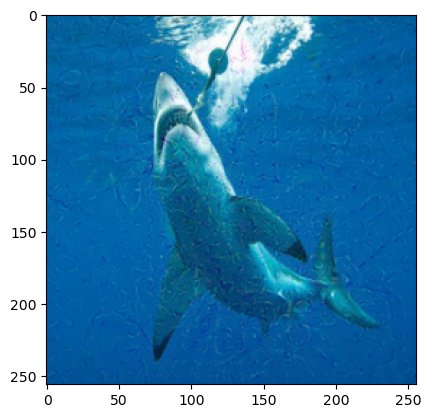

In [ ]:
#show the first 3 images
import matplotlib.pyplot as plt
plt.imshow(cf_imgs[2].permute(1, 2, 0).cpu().numpy())

In [ ]:
#diff =  (init_image - all_samples[j][1:])
diff = gt_imgs-cf_imgs
diff = diff.view(diff.shape[0], -1)
lp1 = int(torch.norm(diff, p=1, dim=-1).mean().cpu().numpy())
lp2 = int(torch.norm(diff, p=2, dim=-1).mean().cpu().numpy())

In [ ]:
lp1, lp2